In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform,)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

# print(type(foreground_classes))

dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
    images, labels = dataiter.next()
    for j in range(batch_size):
        if(classes[labels[j]] in background_classes):
            img = images[j].tolist()
            background_data.append(img)
            background_label.append(labels[j])
        else:
            img = images[j].tolist()
            foreground_data.append(img)
            foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

print("foreground and background created")
    
fg1, fg2, fg3 = 0,1,2  

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
foreground and background created


In [3]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
    """
        bg_idx : list of indexes of background_data[] to be used as background images in mosaic
        fg_idx : index of image to be used as foreground image from foreground data
        fg : at what position/index foreground image has to be stored out of 0-8
    """
    image_list=[]
    j=0
    for i in range(5):  # m value 
        if i != fg:
            image_list.append(background_data[bg_idx[j]])
            j+=1
        else:
            image_list.append(foreground_data[fg_idx])
            label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
    #image_list = np.concatenate(image_list ,axis=0)
    image_list = torch.stack(image_list) 
    return image_list,label

In [4]:
desired_num = 20000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in tqdm(range(desired_num)):
    set_idx = set()
    np.random.seed(i)
    bg_idx = np.random.randint(0,35000,4)
    set_idx = set(background_label[bg_idx].tolist())
    fg_idx = np.random.randint(0,15000)
    set_idx.add(foreground_label[fg_idx].item())
    fg = 0 #np.random.randint(0,5)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)
    list_set_labels.append(set_idx)

100%|██████████| 20000/20000 [00:02<00:00, 8056.24it/s]


In [5]:
len(mosaic_list_of_images),mosaic_list_of_images[0].shape

(20000, torch.Size([5, 3, 32, 32]))

In [6]:
def create_sin_data(mosaic_dataset,labels,fg_n,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches of dimendion 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  """
  n_points = len(mosaic_dataset)
  patches = mosaic_dataset[0].shape[0]
  c = mosaic_dataset[0].shape[1]
  h = mosaic_dataset[0].shape[2]
  w = mosaic_dataset[0].shape[3]

  img = torch.zeros((n_points,patches,c,h,w))

  for i in tqdm(range(len(mosaic_dataset))):
    for j in range(m):
      if j < fg_n:
        img[i][j] = mosaic_dataset[i][0]
      else:
        #print(j)
        index = np.random.randint(1,5,1)
        img[i][j]= mosaic_dataset[i][index]
    
    
  return  img,labels

In [7]:
avg_image_dataset_1 , labels_1 = create_sin_data(mosaic_list_of_images[:10000],mosaic_label[:10000] , 1,5)
avg_image_dataset_2 , labels_2 = create_sin_data(mosaic_list_of_images[:10000],mosaic_label[:10000],2,5)
avg_image_dataset_3 , labels_3= create_sin_data(mosaic_list_of_images[:10000],mosaic_label[:10000] , 3,5)
avg_image_dataset_4 , labels_4 = create_sin_data(mosaic_list_of_images[:10000],mosaic_label[:10000], 4,5 )

avg_image_dataset_5, labels_5= create_sin_data(mosaic_list_of_images[:10000], mosaic_label[:10000] , 5,5)

test_dataset_5, labels_test_5 = create_sin_data(mosaic_list_of_images[10000:],mosaic_label[10000:],5,5)

100%|██████████| 10000/10000 [00:00<00:00, 30647.50it/s]


In [8]:
# avg_image_dataset_1 = torch.stack(avg_image_dataset_1,dim=0)
# avg_image_dataset_2 = torch.stack(avg_image_dataset_2,dim=0)
# avg_image_dataset_3 = torch.stack(avg_image_dataset_3,dim=0)
# avg_image_dataset_4 = torch.stack(avg_image_dataset_4,dim=0)
# avg_image_dataset_5 = torch.stack(avg_image_dataset_5,dim=0)
# test_dataset_5 = torch.stack(test_dataset_5,dim=0)

In [9]:
avg_image_dataset_1.shape

torch.Size([10000, 5, 3, 32, 32])

In [10]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [11]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)



testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)


testdata_6 = MosaicDataset(test_dataset_5, labels_test_5 )
testloader_6 = DataLoader( testdata_6, batch_size= batch ,shuffle=False)


mosaicdata = MosaicDataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000] )
mosaicloader = DataLoader( mosaicdata , batch_size= batch ,shuffle=False)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)

        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.zeros_(self.conv1.bias)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.zeros_(self.conv2.bias)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        torch.nn.init.zeros_(self.fc3.bias)
        torch.nn.init.xavier_normal_(self.fc4.weight)
        torch.nn.init.zeros_(self.fc4.bias)

    def forward(self, z):
        #batch = z.size(0)
        #patches = z.size(1)
        #z = z.view(batch*patches,3,32,32)
        y1 = self.pool(F.relu(self.conv1(z)))
        y1 = self.pool(F.relu(self.conv2(y1)))
        y1 = y1.view(-1, 16 * 5 * 5)

        y1 = F.relu(self.fc1(y1))
        y1 = F.relu(self.fc2(y1))
        y1 = F.relu(self.fc3(y1))
        y1 = self.fc4(y1)
        return y1 

In [13]:
def my_cross_entropy(output,target,loss_criterion):
    
    loss = loss_criterion(output,target)
    #print(final_loss)
    return loss


In [14]:
def calculate_loss_alpha(mosaic_loader,alpha_,net,loss_criterion):
    m = 5
    
    loss_ = []
    with torch.no_grad():
        for i,data in enumerate(mosaic_loader):
            inputs,target =data
            inputs = inputs.double()
            
            
            
            batch = inputs.size(0)
            #print(batch)
            patches = inputs.size(1)
            
            inputs = torch.reshape(inputs,(batch*patches,3,32,32))
            inputs = inputs.to(device)
            outputs = net(inputs)   
            
            target = target.repeat_interleave(patches)
            
            target = target.to(device)
            #print(outputs.shape,target.shape)
            loss = loss_criterion(outputs,target)
            
            loss = torch.reshape(loss,(batch,patches))
            
            loss_weight = torch.ones((batch,patches))*((1-alpha_)/(m-1))
            
            loss_weight[:,0] = alpha_
            
            loss_weight = loss_weight.to(device)
            
            loss = torch.mul(loss_weight,loss)
            
            loss = torch.sum(loss,dim=1)
            loss = torch.sum(loss,dim=0)
            
            loss_.append(loss.item()/batch)
    return np.mean(loss_)

In [15]:
def calculate_loss(trainloader,net,criterion):
    running_loss = 0.0
    ep_lossi = []
    with torch.no_grad():
        for k, data in enumerate(trainloader, 0):
            inputs, labels = data
        
            batch = inputs.shape[0]
            patches = inputs.shape[1]
            c = inputs.shape[2]
            h = inputs.shape[3]
            w = inputs.shape[4]
            inputs = torch.reshape(inputs,(batch*patches,c,h,w))
            labels = labels.repeat_interleave(patches)
            
            inputs = inputs.double()
            inputs, labels = inputs.to(device),labels.to(device)
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            running_loss = loss.item()
            ep_lossi.append(running_loss)
    return np.mean(ep_lossi)

In [16]:
# torch.manual_seed(12)
# net = Net().double()
# net = net.to(device)
# loss_criterion = nn.CrossEntropyLoss(reduction="none")
# calculate_loss_alpha(mosaicloader,0.01,net,loss_criterion)

In [17]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            n_points = images.shape[0]
            patches = images.shape[1]
            c = images.shape[2]
            h = images.shape[3]
            w = images.shape[4]
            images = torch.reshape(images,(n_points*patches,c,h,w))
            labels = labels.repeat_interleave(patches)
            
            images = images.double()
            
            images, labels = images.to(device),labels.to(device)
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [18]:
def train_all(trainloader, ds_number, testloader_list,mosaicloader,alpha):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.00008,weight_decay=5e-5)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 200
    
    loss_alpha_h_curi = []
    
    criterion_ = nn.CrossEntropyLoss(reduction='none')
    if alpha == 1.0:
        alpha_ = alpha
    else:
        alpha_ = alpha+0.1
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        if epoch == 0:    
                loss_curi.append(calculate_loss(trainloader,net,criterion))
        loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            
            n_points = inputs.shape[0]
            patches = inputs.shape[1]
            c = inputs.shape[2]
            h = inputs.shape[3]
            w = inputs.shape[4]
            inputs = torch.reshape(inputs,(n_points*patches,c,h,w))
            labels = labels.repeat_interleave(patches)
            
            inputs = inputs.double()
            
            inputs, labels = inputs.to(device),labels.to(device)
            #print(inputs.shape)
            
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 40
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(calculate_loss(trainloader,net,criterion))   #loss per epoch
    print('Finished Training')
    loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
    torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            n_points = images.shape[0]
            patches = images.shape[1]
            c = images.shape[2]
            h = images.shape[3]
            w = images.shape[4]
            images = torch.reshape(images,(n_points*patches,c,h,w))
            labels = labels.repeat_interleave(patches)
            
            images = images.double()
            
            
            
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi,loss_alpha_h_curi


In [19]:
train_loss_all=[]
train_loss_alpha_h_all = []

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5,testloader_6]



temp1,temp2 = train_all(trainloader_1, 1, testloader_list,mosaicloader,1/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_2, 2, testloader_list,mosaicloader,2/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_3, 3, testloader_list,mosaicloader,3/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_4, 4, testloader_list,mosaicloader,4/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_5, 5, testloader_list,mosaicloader,5/5)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

--------------------------------------------------------------------------------
training on data set   1
[1,    40] loss: 1.097
[2,    40] loss: 1.093
[3,    40] loss: 1.090
[4,    40] loss: 1.087
[5,    40] loss: 1.083
[6,    40] loss: 1.083
[7,    40] loss: 1.080
[8,    40] loss: 1.078
[9,    40] loss: 1.076
[10,    40] loss: 1.074
[11,    40] loss: 1.071
[12,    40] loss: 1.068
[13,    40] loss: 1.066
[14,    40] loss: 1.068
[15,    40] loss: 1.063
[16,    40] loss: 1.064
[17,    40] loss: 1.063
[18,    40] loss: 1.061
[19,    40] loss: 1.059
[20,    40] loss: 1.057
[21,    40] loss: 1.058
[22,    40] loss: 1.056
[23,    40] loss: 1.055
[24,    40] loss: 1.053
[25,    40] loss: 1.054
[26,    40] loss: 1.052
[27,    40] loss: 1.053
[28,    40] loss: 1.050
[29,    40] loss: 1.051
[30,    40] loss: 1.049
[31,    40] loss: 1.049
[32,    40] loss: 1.047
[33,    40] loss: 1.047
[34,    40] loss: 1.046
[35,    40] loss: 1.043
[36,    40] loss: 1.042
[37,    40] loss: 1.044
[38,    40] los

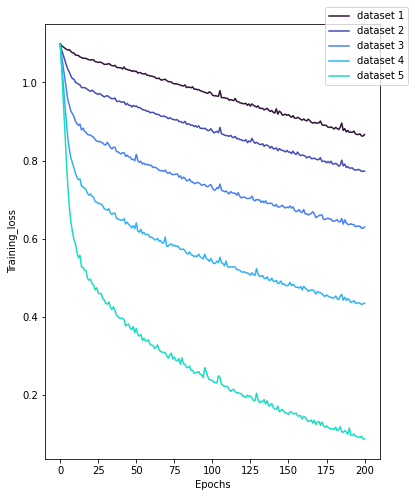

In [20]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
   plt.plot(j,label ="dataset "+str(i+1),color = cm(i*20))
plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))

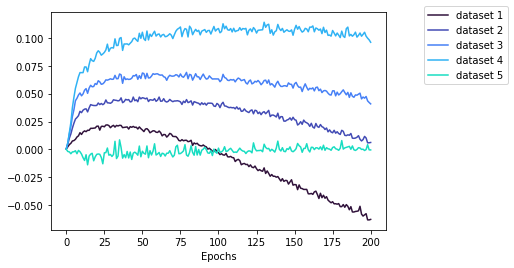

In [21]:
for i in range(len(train_loss_all)):
    temp = np.array(train_loss_all[i]) - np.array(train_loss_alpha_h_all[i])  
    plt.plot(temp,label ="dataset "+str(i+1),color = cm(i*20))
    plt.xlabel("Epochs")
    #plt.ylabel("Training_loss")
    plt.legend(bbox_to_anchor=(1.1, 1.05))

In [22]:
train_loss_alpha_h_all[0]

[1.0989612695872437,
 1.091660120579338,
 1.08668541868946,
 1.0825823027283437,
 1.0775835675815366,
 1.075014089799971,
 1.0750766881052964,
 1.0685381599513666,
 1.0638883741600003,
 1.0605932702673162,
 1.056943494920801,
 1.0538854634512371,
 1.0525480343195297,
 1.049202278381316,
 1.046825389170841,
 1.044911482923067,
 1.0430031252816803,
 1.0429874147411062,
 1.0402267442214455,
 1.0390399688473269,
 1.0365529099179986,
 1.0372755398009104,
 1.0406786939215145,
 1.0326660692873362,
 1.03196929182425,
 1.0309494415536442,
 1.030343486129471,
 1.0292926636807214,
 1.0274094873643569,
 1.0268466887348395,
 1.0258973282322708,
 1.0251960354610996,
 1.0285497148053389,
 1.0238512751015911,
 1.0220592406833322,
 1.0208011953949878,
 1.0224266437589562,
 1.0193593397377083,
 1.018489377607656,
 1.017910629167691,
 1.0172407598672304,
 1.0161011712874213,
 1.0192914265030797,
 1.0143809572389935,
 1.0128659361380425,
 1.0117748279757985,
 1.011628237203542,
 1.010251597097487,
 1.0101

In [23]:
train_loss_all

[[1.0993162235588043,
  1.0939794042145567,
  1.0909856260996569,
  1.088010761582354,
  1.0851070255320139,
  1.0829083456507267,
  1.0840988198479542,
  1.079613327803701,
  1.0760384381045107,
  1.0755912320046324,
  1.0703380291246876,
  1.0694272872502497,
  1.0691403637052044,
  1.0651065127627715,
  1.0640136523749586,
  1.061987579625471,
  1.061923405341429,
  1.0618508481994933,
  1.0592498690039172,
  1.0582652801492258,
  1.0573233559426132,
  1.0581603721531516,
  1.0579738219380472,
  1.0533001624697138,
  1.0527483194064113,
  1.0512118908416945,
  1.0521947828374039,
  1.0512722663831178,
  1.0487653260970575,
  1.0463054103328127,
  1.046702960302369,
  1.0467836097847603,
  1.0485601301831584,
  1.045357476407089,
  1.0430666486784312,
  1.042404769285411,
  1.0439404084947077,
  1.0388994509010274,
  1.0382581513787328,
  1.037941542026036,
  1.037388221530139,
  1.0343600277530745,
  1.0397117853456561,
  1.0342052281154928,
  1.0334887473434098,
  1.031505208223686